# CPTox21: Conformal prediction and exchangeability in in vitro toxicological datasets



In this notebook, it is shown how the experiments for the CPTox21 manuscript (train model and make predictions with Tox21 data, update the training and/or calibration set) are run for multiple endpoints. Furthermore the evaluation over all enpoints in the form of boxplots is provided.

### Import libraries and modules

In [1]:
import pandas as pd
import numpy as np
import math

In [2]:
from sklearn.svm import SVC
from nonconformist.nc import NcFactory, MarginErrFunc
import matplotlib.pyplot as plt

In [3]:
from cptox21 import (
    define_path, load_signatures_files, InductiveConformalPredictor,
    CPTox21AggregatedConformalPredictor, AggregatedConformalPredictor, 
    StratifiedRatioSampler, CrossValidationSampler, KnownIndicesSampler,
    CPTox21CrossValidator, CPTox21TrainUpdateCrossValidator,
    calculate_rmsd_from_df, calculate_rmsd_pos_from_df
)

In [4]:
import warnings
warnings.simplefilter("ignore")

### Define paths and parameters

In [5]:
# Paths
data_signatures_path = "../data/data_signatures/"
data_statistics_path = "../data/data_statistics/"  # Use data from this directory
data_statistics_path = "../../../KT-ER/cptox21_pipeline/data/data_curta_200909/"  # Use data created on the cluster

In [6]:
# Define if model fitting and predictions are required (set to True) or if data are already
# available (set to False)
run_experiment = False #True

In [7]:
# Parameters
n_folds_acp = 3# 10

In [8]:
endpoints = [
    'SR_ATAD5', 'NR_ER', 'NR_AR', 'SR_HSE', 'SR_MMP', 'SR_p53', 'NR_Aromatase',
    'SR_ARE', 'NR_AR_LBD', 'NR_AhR', 'NR_ER_LBD', 'NR_PPAR_gamma'
]

### Define functions

In [9]:
def load_data(endpoint):
    """
    Load signature datasets per endpoint
    
    Parameters
    ----------
    endpoint : endpoint for which the data should be loaded
    
    Returns
    -------
    X_train : (signature) descriptors for Tox21train set
    y_train : labels for Tox21train set
    X_test : (signature) descriptors for Tox21test set
    y_test : labels for Tox21test set
    X_score : (signature) descriptors for Tox21score set
    y_score : labels for Tox21score set
    
    """
    datasets = ["train", "test", "score"]
    train_path = define_path(endpoint=endpoint, data=datasets[0], signatures_path=data_signatures_path)
    test_path = define_path(endpoint=endpoint, data=datasets[1], signatures_path=data_signatures_path)
    score_path = define_path(endpoint=endpoint, data=datasets[2], signatures_path=data_signatures_path)

    X_train, y_train, X_test, y_test, X_score, y_score = load_signatures_files(train_path, test_path, score_path)
    X_train = X_train[:500]
    y_train = y_train[:500]
    return X_train, y_train, X_test, y_test, X_score, y_score

In [10]:
def cross_validate_compare_calibration_sets(
    endpoint, X_train, y_train, X_test, y_test, X_score, y_score
):
    """
    Perform a crossvalidation, including the following settings:
    * use original training and calibration set (Tox21train): predict internal test set (Tox21train)
    * use original training and calibration set: predict score set (Tox21score)
    * use original training and calibration set: predict test set (Tox21test)
    * update calibration set with Tox21test: predict score set
    * update calibration set with part of Tox21score: predict (other) part of Tox21score
    
    Parameters
    ----------
    endpoint : endpoint for which the data should be loaded
    
    X_train : (signature) descriptors for Tox21train set
    y_train : labels for Tox21train set
    X_test : (signature) descriptors for Tox21test set
    y_test : labels for Tox21test set
    X_score : (signature) descriptors for Tox21score set
    y_score : labels for Tox21score set
    
    Returns
    -------
    cross_validator : cross_validator class with fitted and calibrated models and evaluation dfs
    """
    cross_validator = CPTox21CrossValidator(
            acp, cv_splitter=CrossValidationSampler(),
            score_splitter=StratifiedRatioSampler(test_ratio=0.5)
        )
    cross_validation_dfs = cross_validator.cross_validate(
            steps=10,
            endpoint=endpoint,
            X_train=X_train,
            y_train=y_train,
            X_update=X_test,
            y_update=y_test,
            X_score=X_score,
            y_score=y_score,
        )
    return cross_validator

In [11]:
def cross_validate_with_updated_training_set(
    endpoint, X_train, y_train, X_test, y_test, X_score, y_score, known_indices_sampler
):
    
    """
    Perform a crossvalidation, including the following settings:
    * update original training set (Tox21train) with Tox21test: predict internal test set (Tox21train & Tox21test)
    * update original training set (Tox21train) with Tox21test: predict score set (Tox21score)
        
    Parameters
    ----------
    endpoint : endpoint for which the data should be loaded
    
    X_train : (signature) descriptors for Tox21train set
    y_train : labels for Tox21train set
    X_test : (signature) descriptors for Tox21test set
    y_test : labels for Tox21test set
    X_score : (signature) descriptors for Tox21score set
    y_score : labels for Tox21score set
    
    known_indices_sampler: Sampler to split X_train and y_train in the same train and test sets
    as used (known) for the previous experiments
    
    Returns
    -------
    cross_validator : cross_validator class with fitted and calibrated models and evaluation dfs
    """
    train_update_cross_validator = CPTox21TrainUpdateCrossValidator(
    train_update_acp, cv_splitter=known_indices_sampler
)

    train_update_cross_validation_dfs = train_update_cross_validator.cross_validate(steps=10,
                                           endpoint=endpoint,
                                           X_train=X_train,
                                           y_train=y_train,
                                           X_update=X_test,
                                           y_update=y_test,
                                           X_score=X_score,
                                           y_score=y_score,
                                           class_wise_evaluation=False)
    return train_update_cross_validator

In [12]:
def boxplot_rmsd(rmsds, rmsd_title, strategies=None):
    if strategies is None:
        strategies = ["cv_original", "pred_score_original", "pred_score_trainupdate",
              "pred_score_calupdate", "pred_score_calupdate2"]
    """
    Generate a boxplot with the rmsd values over multiple endpoints.
    This function can be used to plot both rmsd or rmsd_pos values.
    
    Parameters
    ----------
    strategies : strategies or set-ups used when making the predictions (e.g. "original_cv")
    rmsds : a dictionary with the strategies as keys and a list of rmsd values for all the
        endpoints as values
    rmsd_title : the naming for 'rmsd' which should be used in the plot title, e.g. "rmsd", "rmsd_pos"
    """
    plt.clf()
    plt.boxplot([rmsds[k] for k in strategies], labels=strategies)
    plt.xticks(rotation='vertical')
    plt.title(f"{rmsd_title} over all endpoints")

### Build conformal predictors

In [13]:
# Build ICP
clf = SVC(kernel='rbf', C=50, gamma=0.002, probability=True)
error_function = MarginErrFunc()
normaliser_model = None
nc = NcFactory.create_nc(clf, err_func=error_function)
icp = InductiveConformalPredictor(
    nc_function=nc, condition=(lambda instance: instance[1])
)  # Mondrian as (default) condition)

In [14]:
# Build ACP (uses original and updated calibration sets)
acp = CPTox21AggregatedConformalPredictor(
        predictor=icp, sampler=StratifiedRatioSampler(n_folds=n_folds_acp),
        aggregation_func=np.median
    )

In [15]:
# Build ACP (accepts only one calibration set, used with updated training set)
train_update_acp = AggregatedConformalPredictor(
        predictor=icp, sampler=StratifiedRatioSampler(n_folds=n_folds_acp),
        aggregation_func=np.median
    )

### Run experiments

In [16]:
evaluation_dfs = {"cv_original": [],
                  "pred_score_original": [],
#                   "pred_score_scp": [],  # Uncomment if SCP results are available
                 "pred_score_calupdate": [], "pred_score_calupdate2": [],
                  "cv_trainupdate": [], "pred_score_train_update": []}

for endpoint in endpoints:
    print(endpoint)
    if run_experiment: # If we want to make calculations for all set-ups
        
        # Load data
        X_train, y_train, X_test, y_test, X_score, y_score = load_data(endpoint)
        
        # Cross-validate with different calibration sets
        cptox21_cross_validator = cross_validate_compare_calibration_sets(
            endpoint, X_train, y_train, X_test, y_test, X_score, y_score
        )
        
        # Store dataframes with evaluation measures per set-up
        evaluation_dfs["cv_original"].append(cptox21_cross_validator.averaged_evaluation_df_cv)
        evaluation_dfs["pred_score_original"].append(
            cptox21_cross_validator.averaged_evaluation_df_pred_score
        )
        evaluation_dfs["pred_score_calupdate"].append(
            cptox21_cross_validator.averaged_evaluation_df_pred_cal_update
        )
        evaluation_dfs["pred_score_calupdate2"].append(
            cptox21_cross_validator.averaged_evaluation_df_pred_cal_update2
        )
        
        cptox21_cross_validator.averaged_evaluation_df_cv.to_csv(
            f"{data_statistics_path}{endpoint}_averaged_eval_df_cv.csv"
        )
        cptox21_cross_validator.averaged_evaluation_df_pred_score.to_csv(
            f"{data_statistics_path}{endpoint}_averaged_eval_df_pred_score.csv"
        )
        cptox21_cross_validator.averaged_evaluation_df_pred_test.to_csv(
            f"{data_statistics_path}{endpoint}_averaged_eval_df_pred_test.csv"
        )
        cptox21_cross_validator.averaged_evaluation_df_pred_cal_update.to_csv(
            f"{data_statistics_path}{endpoint}_averaged_eval_df_cal_update.csv"
        )
        cptox21_cross_validator.averaged_evaluation_df_pred_cal_update2.to_csv(
            f"{data_statistics_path}{endpoint}_averaged_eval_df_cal_update2.csv"
        )
        
        train_index, test_index = cptox21_cross_validator.train_indices, cptox21_cross_validator.test_indices
        known_indices_sampler = KnownIndicesSampler(
            known_train=train_index, known_test=test_index
        )

        train_update_cross_validator = cross_validate_with_updated_training_set(
            endpoint, X_train, y_train, X_test, y_test, X_score, y_score, known_indices_sampler
        )

        evaluation_dfs["cv_trainupdate"].append(train_update_cross_validator.averaged_evaluation_df_cv)
        evaluation_dfs["pred_score_train_update"].append(train_update_cross_validator.averaged_evaluation_df_pred_score)
    
        train_update_cross_validator.averaged_evaluation_df_cv.to_csv(
            f"{data_statistics_path}{endpoint}_averaged_eval_df_cv_train_update.csv"
        )
        train_update_cross_validator.averaged_evaluation_df_pred_score.to_csv(
            f"{data_statistics_path}{endpoint}_averaged_eval_df_pred_score_train_update.csv"
        )
        
    else: # If results are already available and dataframes can be loaded directly
        cv_original_df = pd.read_csv(f"{data_statistics_path}{endpoint}_averaged_eval_df_cv.csv")
        evaluation_dfs["cv_original"].append(cv_original_df)
        pred_score_original_df = pd.read_csv(
            f"{data_statistics_path}{endpoint}_averaged_eval_df_pred_score.csv"
        )
        evaluation_dfs["pred_score_original"].append(pred_score_original_df)
        pred_test_original_df = pd.read_csv(
            f"{data_statistics_path}{endpoint}_averaged_eval_df_pred_test.csv"
        )
        # Uncomment if SCP results are available and should be compared
#         pred_score_scp_df = pd.read_csv(
#             f"{data_statistics_path}{endpoint}_averaged_eval_df_pred_score_scp.csv"
#         )
#         evaluation_dfs["pred_score_scp"].append(pred_score_scp_df)
        pred_score_calupdate_df = pd.read_csv(
            f"{data_statistics_path}{endpoint}_averaged_eval_df_cal_update.csv"
        )
        evaluation_dfs["pred_score_calupdate"].append(pred_score_calupdate_df)
        pred_score_calupdate2_df = pd.read_csv(
             f"{data_statistics_path}{endpoint}_averaged_eval_df_cal_update2.csv"
        )
        evaluation_dfs["pred_score_calupdate2"].append(pred_score_calupdate2_df)
        cv_trainupdate_df = pd.read_csv(
            f"{data_statistics_path}{endpoint}_averaged_eval_df_cv_train_update.csv"
        )
        evaluation_dfs["cv_trainupdate"].append(cv_trainupdate_df)
        pred_score_train_update_df = pd.read_csv(
            f"{data_statistics_path}{endpoint}_averaged_eval_df_pred_score_train_update.csv"
        )
        evaluation_dfs["pred_score_train_update"].append(pred_score_train_update_df)

SR_ATAD5
NR_ER
NR_AR
SR_HSE
SR_MMP
SR_p53
NR_Aromatase
SR_ARE
NR_AR_LBD
NR_AhR
NR_ER_LBD
NR_PPAR_gamma


### Calculate rmsd's for all endpoints over all strategies

To have a value to compare the calibration plots (validity) over all experiments, we calculate the rmsd of the observed error rate to the expected error rate (for 10 significance levels). If we accept overconservative validity, we can also calculate rmsd_pos (todo: change term/name?), only considering the deviation where the observed error rate is higher than the expected error rate.

In [17]:
rmsds = {}
for k, v in evaluation_dfs.items():
    rmsds[k] = []
    for df in v:
        
        rmsd = calculate_rmsd_from_df(df)
        rmsds[k].append(rmsd)

pd.DataFrame(rmsds, index=endpoints)

,cv_original,pred_score_original,pred_score_calupdate,pred_score_calupdate2,cv_trainupdate,pred_score_train_update
SR_ATAD5,0.012,0.060,0.016,0.015,0.012,0.065
NR_ER,0.022,0.047,0.059,0.016,0.023,0.040
NR_AR,0.030,0.041,0.064,0.027,0.028,0.033
SR_HSE,0.019,0.045,0.058,0.015,0.022,0.037
SR_MMP,0.011,0.034,0.043,0.013,0.013,0.023
SR_p53,0.012,0.069,0.067,0.025,0.015,0.058
NR_Aromatase,0.013,0.029,0.042,0.023,0.012,0.027
SR_ARE,0.016,0.079,0.036,0.015,0.017,0.067
NR_AR_LBD,0.018,0.039,0.061,0.019,0.018,0.033
NR_AhR,0.015,0.069,0.064,0.022,0.018,0.060


### Calculate rmsd_pos's for all endpoints over all strategies

In [18]:
rmsds_pos = {}
for k, v in evaluation_dfs.items():
    rmsds_pos[k] = []
    for df in v:
        rmsd_pos = calculate_rmsd_pos_from_df(df)
        rmsds_pos[k].append(rmsd_pos)
pd.DataFrame(rmsds_pos, index=endpoints)

,cv_original,pred_score_original,pred_score_calupdate,pred_score_calupdate2,cv_trainupdate,pred_score_train_update
SR_ATAD5,0.010,0.060,0.000,0.013,0.009,0.065
NR_ER,0.019,0.047,0.008,0.015,0.018,0.040
NR_AR,0.028,0.041,0.004,0.020,0.025,0.032
SR_HSE,0.014,0.045,0.052,0.015,0.017,0.037
SR_MMP,0.009,0.034,0.022,0.003,0.009,0.023
SR_p53,0.008,0.069,0.000,0.025,0.008,0.058
NR_Aromatase,0.012,0.029,0.027,0.023,0.010,0.027
SR_ARE,0.013,0.079,0.026,0.011,0.013,0.067
NR_AR_LBD,0.016,0.039,0.000,0.018,0.014,0.033
NR_AhR,0.011,0.069,0.009,0.020,0.011,0.060


### Plot boxplot

Given the rmsds per endpoint, we can draw a boxplot over the rmsd values for all endpoints. This gives us a nice overview on how the rmsds change among the different CP set-ups.

In [19]:
strategies = ["cv_original", 
              "pred_score_original",
#               "pred_score_scp",  # Uncomment, if SCP data are available
              "pred_score_train_update",
              "pred_score_calupdate", 
              "pred_score_calupdate2"]

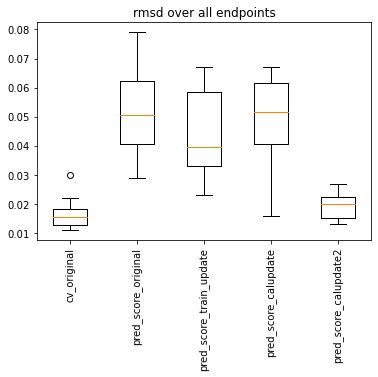

In [20]:
boxplot_rmsd(rmsds, "rmsd", strategies)

todo: more description here, 
1) on what we see, and 
2) on why we also consider rmsd pos. 

Description/discussion will be added here, once the statements of the paper are clear.

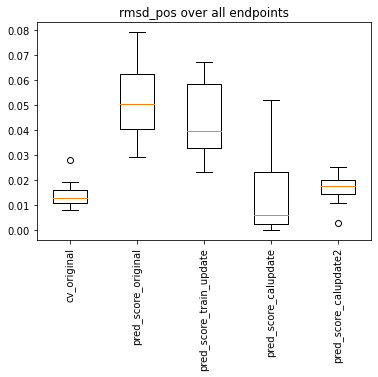

In [21]:
boxplot_rmsd(rmsds_pos, "rmsd_pos", strategies)

To see how the rmsds change for the individual endpoints and detect possible "outlier endpoints", we can look at the following line plots.

Note, that these plots were initially used for internal investigation, e.g. which endpoints should be selected as example in the manuscript. If unnecessary, the plots can be deleted from this SI notebook.

In [22]:
def line_plot_rmsd(rmsds, strategies, colours=None, markers=None):
    plt.clf()
    fig = plt.figure(figsize=(10,20))
    if colours is None:
        colours = ['navy', 'royalblue', 'blueviolet', 'plum', 'mediumvioletred', 'red', 'coral', 'gold', 'yellowgreen', 'green', 'paleturquoise', 'slategrey']
    if markers is None:
        markers = ['3', '<', '>', 'x', 's', '+', 'd', 'h', '*', '1', 'o', 'D']
    for i, ep in enumerate(endpoints):
    
        plt.plot(strategies, [rmsds[s][i] for s in strategies], color=colours[i], linewidth=0.5)#, marker='-o')
        plt.scatter(strategies, [rmsds[s][i] for s in strategies], label=ep, color=colours[i], marker=markers[i], s=50)
        plt.xticks(rotation='vertical')
        plt.legend(endpoints, loc='upper right')#, bbox_to_anchor=(1, 0.5))
    

<Figure size 432x288 with 0 Axes>

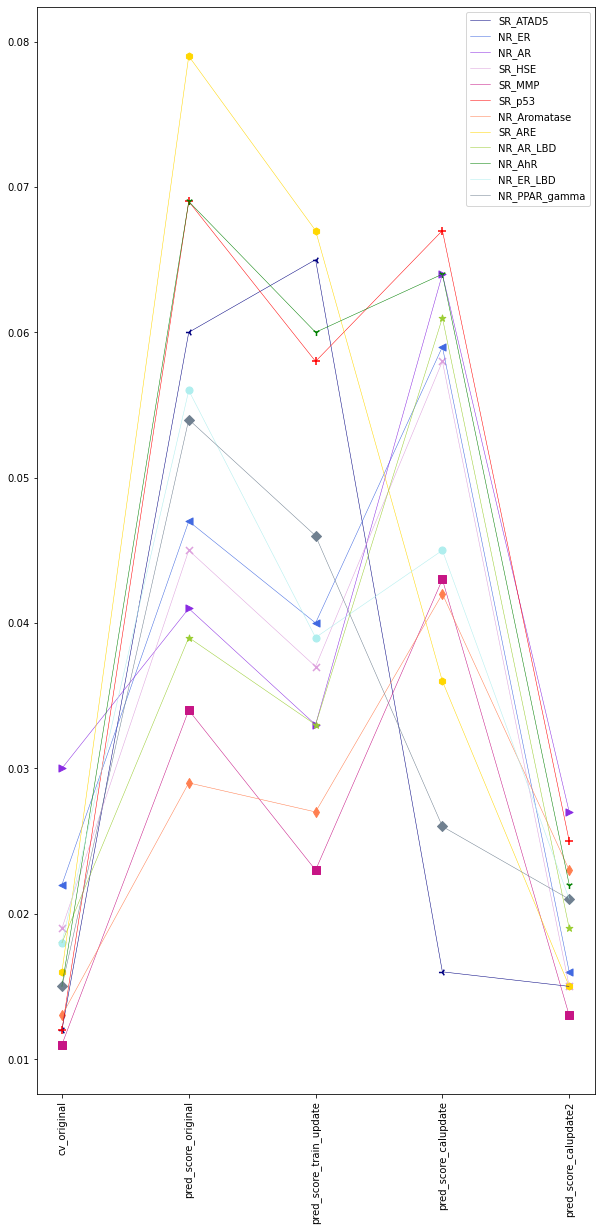

In [23]:
line_plot_rmsd(rmsds, strategies)

<Figure size 432x288 with 0 Axes>

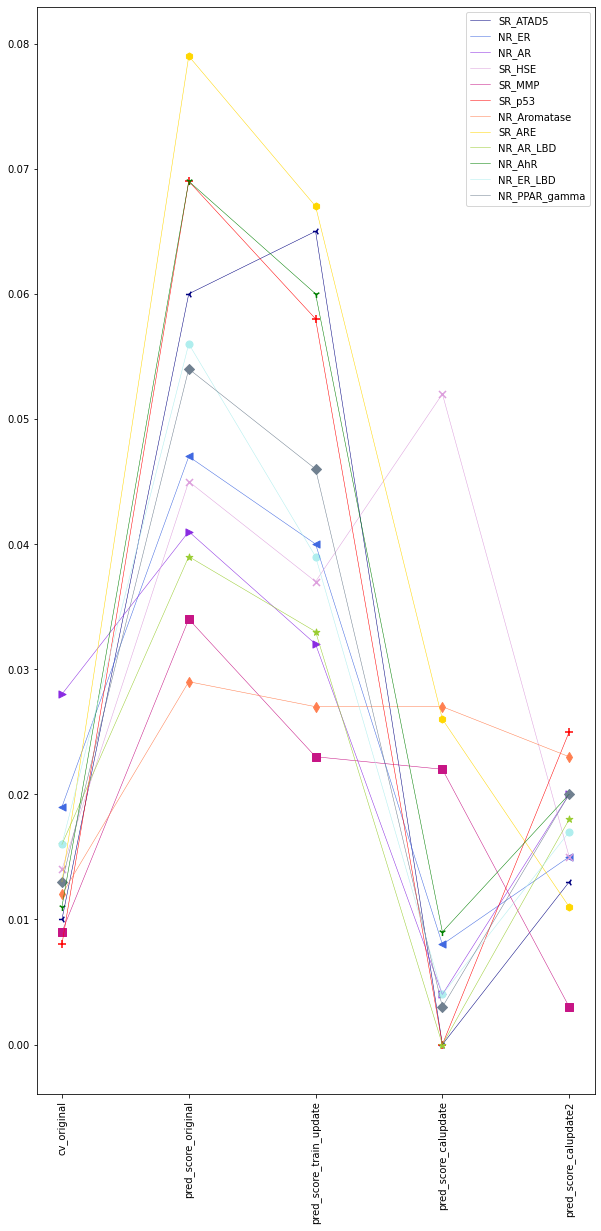

In [24]:
line_plot_rmsd(rmsds_pos, strategies)